<a href="https://colab.research.google.com/github/MrDevCop/Quantization/blob/main/Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Quantization & De-quantization



What is quantization?

 

1.   It means given a range of values,  𝑋={𝑥1,𝑥2,…𝑥𝑛}  and a desired precision of 𝑘  bits.
2.   Find the minimum and maximum values of X,  𝑥𝑚𝑎𝑥  and  𝑥𝑚𝑖𝑛 .
3.   Find the minimum and maximum value of the bits, namely  𝑞𝑚𝑖𝑛=0  and  𝑞𝑚𝑎𝑥=2𝑘−1 .
4.   Set  𝑠𝑐𝑎𝑙𝑒=(𝑥𝑚𝑎𝑥−𝑥𝑚𝑖𝑛)/𝑞𝑚𝑎𝑥 .
5.   Note that besides scaling, we also have to consider the bias , or what  0  will map to. Set  𝑧𝑒𝑟𝑜𝑝𝑜𝑖𝑛𝑡  as follows:

     a. If  𝑥𝑚𝑖𝑛≥0 ,  𝑧𝑒𝑟𝑜𝑝𝑜𝑖𝑛𝑡=0  \ b. Else if  𝑥𝑚𝑎𝑥<0        𝑧𝑒𝑟𝑜𝑝𝑜𝑖𝑛𝑡=𝑞𝑚𝑎𝑥 .
c. Else  𝑧𝑒𝑟𝑜𝑝𝑜𝑖𝑛𝑡=−𝑥𝑚𝑖𝑛/𝑠𝑐𝑎𝑙𝑒 . \ d. https://docs.openvinotoolkit.org/latest/pot_compression_algorithms_quantization_README.html




6.   The formula for quantization of  𝑥  then becomes:  
𝑄(𝑥,𝑏𝑖𝑡𝑠)=𝑟𝑜𝑢𝑛𝑑(𝑥𝑠𝑐𝑎𝑙𝑒+𝑧𝑒𝑟𝑜𝑝𝑜𝑖𝑛𝑡) .
7.   The formula to dequantize becomes:  
𝐷𝑄(𝑥,𝑠𝑐𝑎𝑙𝑒,𝑧𝑒𝑟𝑜𝑝𝑜𝑖𝑛𝑡,𝑛𝑢𝑚−𝑏𝑖𝑡𝑠)=𝑠𝑐𝑎𝑙𝑒∗(𝑓𝑙𝑜𝑎(𝑥)−𝑧𝑒𝑟𝑜𝑝𝑜𝑖𝑛𝑡) .











We work through a quick example. Consider the values 𝑋=[1,3,4,14], 𝑘=4. \ Then 𝑞𝑚𝑎𝑥=15 and 𝑠𝑐𝑎𝑙𝑒=13/15. 𝑧𝑒𝑟𝑜𝑝𝑜𝑖𝑛𝑡=0. \ The quantization becomes: 𝑟𝑜𝑢𝑛𝑑([0,30/13,45/13,195/13])=[0,2,3,15].

The dequantization becomes 1315∗([0,2,3,15])=[0,1.733,2.6,13].



In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import namedtuple
from torch import tensor

QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])

In [10]:
def calcScaleZeroPoint(min_val, max_val, num_bits):
    
    qmax = 2**num_bits - 1
    scale = (max_val - min_val)/qmax
    
    if min_val >=0:
        zero_point = 0
    elif max_val < 0:
        zero_point = qmax
    else:
        zero_point = -min_val/scale
    
    
        
    return (scale, zero_point)    
  #pass
  # Return scale and zero point.
  # Use formulas 3 and 4 above.

def quantize_tensor(float_x: tensor, num_bits: int):
    
    maximum = torch.max(float_x)
    minimum = torch.min(float_x)
    scale , zeropoint = calcScaleZeroPoint(minimum, maximum, num_bits)

    q_tensor = (float_x/scale) + zeropoint
    q_tensor = q_tensor.clamp_(minimum, maximum)
    q_tensor = torch.round(q_tensor)
    q_tensor = q_tensor.float()
    
    #QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])
    Q_T = QTensor(q_tensor, scale, zeropoint)
    
    return (Q_T)
  #pass
  # Return a QTensor tuple, with the quantized tensor, scale and zero point as described above.
  # Use calcScaleZeroPoint and formula 6 above.


def dequantize_tensor(quantized_x: tensor, scale: float, zero_point: float):
    
    dq_tensor = scale * (quantized_x.float() - zero_point)
    return (dq_tensor)
#  pass
  # Return float_tensor. 

Verification of `quantize_tensor` and `dequantize_tensor`

In [5]:
# Defining a random tensor
a = torch.tensor([2,0.9,41,52])

# Checking quantize_tensor function
tup = quantize_tensor(a,4)
tup.tensor

tensor([ 1.,  1., 12., 15.])

In [6]:
tup.scale

tensor(3.4067)

In [7]:
tup.zero_point

0

In [9]:
# Checking dequantize_tensor function
d_a = dequantize_tensor(tup.tensor, tup.scale, tup.zero_point)
d_a

tensor([ 3.4067,  3.4067, 40.8800, 51.1000])

MNIST

We now train a basic MNIST model. 

In [11]:
# You don't need to edit any of this code.
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


class Net(nn.Module):
    def __init__(self, mnist=True):
      
        super(Net, self).__init__()
        if mnist:
          num_channels = 1
        else:
          num_channels = 3
          
        self.conv1 = nn.Conv2d(num_channels, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
      
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)  
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [12]:

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
   
        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def main():
 
    batch_size = 64
    test_batch_size = 64
    epochs = 5
    lr = 0.01
    momentum = 0.5
    seed = 1
    log_interval = 500
    save_model = False
    no_cuda = False
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)
    
  
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    args = {}
    args["log_interval"] = log_interval
    for epoch in range(1, epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)

    if (save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")
    
    return model

model = main()

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292215
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.255719

Test set: Average loss: 0.1194, Accuracy: 9627/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.132260
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.055792

Test set: Average loss: 0.0755, Accuracy: 9749/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.056983
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.026856

Test set: Average loss: 0.0511, Accuracy: 9845/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.040046
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.019234

Test set: Average loss: 0.0459, Accuracy: 9837/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.023508
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.009386

Test set: Average loss: 0.0323, Accuracy: 9889/10000 (99%)



In [13]:
# These are driver functions for your code. You do not need to edit.
def quantForward(model, input, num_bits):
  quantized_input = quantize_tensor(input, num_bits)
  output_1  = F.relu(model.conv1(quantized_input.tensor))
  output_2 = F.max_pool2d(quantize_tensor(output_1, num_bits).tensor, 2, 2)
  output_3 = F.relu(model.conv2(quantize_tensor(output_2, num_bits).tensor))
  output_4 = F.max_pool2d(quantize_tensor(output_3, num_bits).tensor, 2, 2)
  output_5 = output_4.view(-1, 4*4*50)
  output_6 = F.relu(model.fc1(quantize_tensor(output_5, num_bits).tensor))
  output_7 = model.fc2(quantize_tensor(output_6, num_bits).tensor)
  return F.log_softmax(quantize_tensor(output_7, num_bits).tensor, dim=1)

def testQuant(model, test_loader, quant=False, num_bits=8):
    device = 'cuda'
    
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if quant:
              output = quantForward(model, data, num_bits)
            else:
              output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (round(100*correct/len(test_loader.dataset)))

In [14]:
kwargs = {'num_workers': 1, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True, **kwargs)

In [18]:
acc = testQuant(model, test_loader, quant=True, num_bits=16)



Test set: Average loss: 2.3166, Accuracy: 980/10000 (10%)



##Checking the realtion between `number of bits` and `accuracy`

In [19]:
bits = 16
acc_list = []
no_bits = []
for b in range(bits):
  temp =  testQuant(model, test_loader, quant=True, num_bits=b+1)
  print("\nNumber of bits are {} and accuracy is {}%".format(b+1,temp))
  no_bits.append(b+1)
  acc_list.append(temp)
  #eprint(b)


Test set: Average loss: 2.2356, Accuracy: 1294/10000 (13%)


Number of bits are 1 and accuracy is 13%

Test set: Average loss: 1.4614, Accuracy: 6828/10000 (68%)


Number of bits are 2 and accuracy is 68%

Test set: Average loss: 0.6779, Accuracy: 9636/10000 (96%)


Number of bits are 3 and accuracy is 96%

Test set: Average loss: 0.2353, Accuracy: 9688/10000 (97%)


Number of bits are 4 and accuracy is 97%

Test set: Average loss: 5.3073, Accuracy: 3241/10000 (32%)


Number of bits are 5 and accuracy is 32%

Test set: Average loss: 21.5271, Accuracy: 1289/10000 (13%)


Number of bits are 6 and accuracy is 13%

Test set: Average loss: 49.1244, Accuracy: 1055/10000 (11%)


Number of bits are 7 and accuracy is 11%

Test set: Average loss: 51.3691, Accuracy: 1215/10000 (12%)


Number of bits are 8 and accuracy is 12%

Test set: Average loss: 16.0480, Accuracy: 1419/10000 (14%)


Number of bits are 9 and accuracy is 14%

Test set: Average loss: 3.9928, Accuracy: 1132/10000 (11%)


Number 

In [17]:
print(acc_list) # Prints a list of accuracy measures for different number of bits
print(no_bits) # Prints the number of bits


[14, 67, 96, 97, 33, 13, 11, 12, 14, 11, 10, 10, 10, 10, 10, 10]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


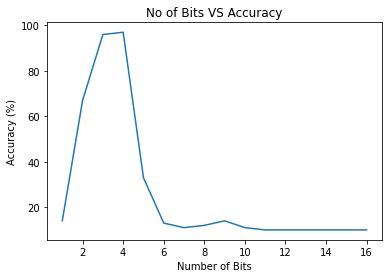

In [18]:
 
plt.plot(no_bits, acc_list)
  
plt.xlabel('Number of Bits')

plt.ylabel('Accuracy (%)')
  

plt.title('No of Bits VS Accuracy')
  

plt.show()